# Analysis of Whisper Fine-tuning Results

This notebook loads traning results from the fine-tine notebooks' JSON output and draws graphs.

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 30.7 MB/s 
     |████████████████████████████████| 7.6 MB 49.1 MB/s 
     |████████████████████████████████| 182 kB 75.7 MB/s 


In [ ]:
from transformers import Seq2SeqTrainingArguments
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Save package

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-ft-libri-en",  # change to a repo name of your choice
    per_device_train_batch_size=8, # paper: 256, orig: 16
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=7.740176574997311e-05, # paper: 5e-4, orig: 1e-5
    warmup_steps=2, # paper: 2048, orig: 2
    max_steps=400, # paper: 1048576, orig: 100
    gradient_checkpointing=True,
    fp16=True,
    group_by_length=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=20, 
    eval_steps=5,
    logging_steps=1,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    seed = 42,
    push_to_hub=True,
    # paper below
    optim="adamw_torch",
    weight_decay = 0.1146914, 
    #adam_bata1 = 0.9,
    adam_beta2 = 0.98,
    adam_epsilon = 1e-6,
    max_grad_norm = 1.0
)

# Note: 'paper' refers to https://arxiv.org/abs/2212.04356 and 'orig' to original
# verson of this notebook. Our values are the best tuning we could achieve (with
# our resource limitaitons).

In [ ]:
def package_results(training_args, results_path):
  """ Package finetune hyperparams and results into a dict """
  pkg = {}

  # save hyperparmeters
  pkg['hyperparams'] = training_args.to_dict()

  # save training results
  with open(results_path, 'r') as f:
    res_from_file = json.load(f)

  eval_steps = []
  log_steps = []
  for log in res_from_file['log_history']:
    if 'eval_loss' in log.keys():
      eval_steps.append(log)
    else:
      log_steps.append(log)

  res = {}
  res['ep'] = [s['epoch'] for s in log_steps]
  res['lr'] = [s['learning_rate'] for s in log_steps]
  res['loss'] = [s['loss'] for s in log_steps]
  res['eval_ep'] = [s['epoch'] for s in eval_steps]
  res['eval_loss'] = [s['eval_loss'] for s in eval_steps]
  res['eval_wer'] = [s['eval_wer'] for s in eval_steps]

  pkg['results'] = res
  return pkg

In [ ]:
pkg = package_results(training_args, '/content/trainer_state.json')
with open('whisperFT_exp08.json', 'w') as f:
  json.dump(pkg, f)

# Load and plot

In [ ]:
def plt_eval_loss(pkg):
  res = pkg['results']
  plt.plot(res['eval_ep'], res['eval_loss'], 'x-')
  plt.title('Evaluation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()

def plt_eval_wer(pkg):
  res = pkg['results']
  plt.plot(res['eval_ep'], res['eval_wer'], 'x-')
  plt.title('Word error rate')
  plt.xlabel('epoch')
  plt.ylabel('WER')
  plt.show()

def get_stats(pkg):
  res = pkg['results']
  data = \
  {
      "eval_epoch": res['eval_ep'],
      "eval_loss": res['eval_loss'],
      "WER": res['eval_wer']
  }
  return pd.DataFrame(data)

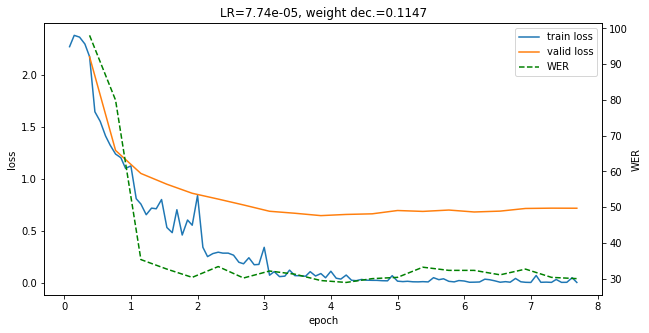

In [ ]:
# losses and WER
for n in [8]:
  path = f"whisperFT_exp0{n}.json"
  with open(path, 'r') as f:
    pkg = json.load(f)

  res = pkg['results']
  hyp = pkg['hyperparams']

  fig, ax1 = plt.subplots(figsize=(10, 5))
  ax2 = ax1.twinx()
  lns1 = ax1.plot(res['ep'], res['loss'], '-', label="train loss")
  lns2 = ax1.plot(res['eval_ep'], res['eval_loss'], '-', label="valid loss")
  lns3 = ax2.plot(res['eval_ep'], res['eval_wer'], '--', label="WER", color='g')

  ax1.set_title(f"LR={hyp['learning_rate']:.4}, weight dec.={hyp['weight_decay']:.4}")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax2.set_ylabel('WER')
  lns = lns1+lns2+lns3
  labs = [l.get_label() for l in lns]
  ax1.legend(lns, labs, loc=0)
  plt.show()

# Sandbox

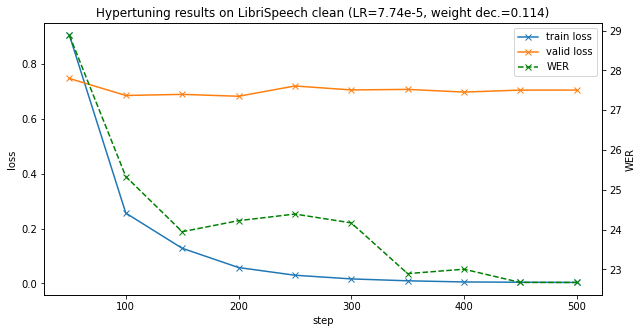

In [ ]:
ep = np.linspace(50,500,10)
loss = \
[
  0.9048,
  0.2567,
  0.1284,
  0.0582,
  0.0301,
  0.0167,
  0.0098,
  0.0056,
  0.0046,
  0.0038
]
eval_loss = \
[
  0.747488,
  0.685584,
  0.689597,
  0.682746,
  0.720203,
  0.705789,
  0.707749,
  0.697938,
  0.705192,
  0.705268
]
wer = \
[
  28.880266,
  25.332594,
  23.946785,
  24.223947,
  24.390244,
  24.168514,
  22.89357,
  23.004435,
  22.67184,
  22.67184
]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
lns1 = ax1.plot(ep, loss, 'x-', label="train loss")
lns2 = ax1.plot(ep, eval_loss, 'x-', label="valid loss")
lns3 = ax2.plot(ep, wer, 'x--', label="WER", color='g')

ax1.set_title(f"Hypertuning results on LibriSpeech clean (LR=7.74e-5, weight dec.=0.114)")
ax1.set_xlabel('step')
ax1.set_ylabel('loss')
ax2.set_ylabel('WER')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()